In [12]:
%%writefile buchi.py
from reachability import Reachability
from math import inf
from safety import largest_fixpoint

class Buchi(Reachability):
    """Compute energy needed to safely satisy Büchi objective
    for a target set `targets`

    `targets` : `set of ints` target states
    """

    def __init__(self, mdp, targets, cap = inf):
        Reachability.__init__(self, mdp, targets, cap)

        self.buchi_values = None
        self.buchi_safe   = [inf] * self.states

        self.get_safe_values()

    def get_Buchi(self, recompute=False):
        """Return (and compute) minimal levels for Buchi
        objective with `self.targets` and `self.capacity`.

        When called for the first time, compute the values.
        Recomputes the values if requested by `recompute`.

        A Bellman-style equation largest fixpoint solver.

        We start with ∞ for every state that is not target,
        and with sufficient level (for survival) for target
        and propagate the safe energy needed to reach T in a
        backward manner. After a fixpoint is reached, we remove
        the reload states that have the value equal to ∞ and
        proceed with another computation.

        In contrast to almostSureReachability here we do not set
        the buchi_safe values of targets to safe_values after 
        each iteration. This si because after reaching a target,
        we still need to reach target again.

        The first iteration (the first fixpoint achieved) is equal
        to positive reachability.
        """
        if not recompute and self.buchi_values is not None:
            return self.buchi_values

        # removed stores reloads that had been removed from the MDP
        removed = set()

        done = False
        while not done:
            # Compute fixpoint without removed reloads

            # Recompute the "safe for buchi" values with removed reloads.
            # Store them in `buchi_safe`.
            # The meaning is:
            #  1. survive without removed reloads from all states (even targets)
            #
            # Uses sufficient_levels computation initialized with removed
            # Basically is a simple survival level computation with removed state
            self.sufficient_levels(removed, self.buchi_safe)

            # Mitigate reload removal
            rem_survival_val = lambda s: inf if s in removed else self.buchi_safe[s]
            rem_action_value = lambda a, v: self.action_value_T(a, v, rem_survival_val)

            # Removed reloads are skipped
            is_removed = lambda x: x in removed # Improve performance only
            is_target  = lambda x: x in self.targets # Improve performance only
            # Over capacity values -> ∞

            # Initialize buchi_values:
            #  * buchi_safe for target states
            #  * inf otherwise
            self.buchi_values = [inf] * self.states
            for t in self.targets:
                self.buchi_values[t] = self.buchi_safe[t]

            largest_fixpoint(self.mdp, self.buchi_values,
                             rem_action_value,
                             value_adj=self.reload_capper,
                             skip_state=is_removed or is_target)

            done = True
            # Iterate over reloads and remove unusable ones (∞)
            for s in range(self.states):
                if self.is_reload(s) and self.buchi_values[s] == inf:
                    if s not in removed:
                        removed.add(s)
                        done = False

        return self.buchi_values

Overwriting buchi.py


In [1]:
!python3 test.reachability.py

In [9]:
import buchi
from reachability_examples import ultimate

m, targets = ultimate()

In [12]:
m.get_Buchi(targets, 15)

[6, inf, inf, 3, 0, 1, 10, inf, 4, inf, inf]

3


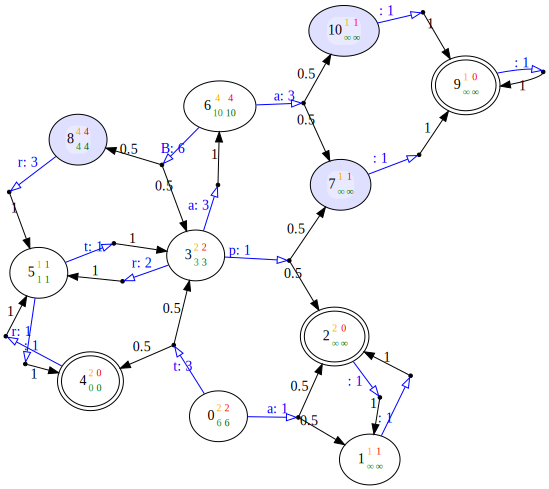

In [13]:
m